# EnMAP Background-Matched Uncertainty Analysis

Quantify plume uncertainty by combining the matched-filter concentration map with its propagated detector noise while constraining the clutter term to plume-free pixels that share the same background as the plume. Spectral distance is evaluated on methane-insensitive bands so methane absorption does not bias the reference spectrum.

**Highlights**
1. Load the MF concentration/uncertainty rasters and optional plume polygons.
2. Read the original EnMAP radiance cube to capture the full spectrum outside the two SWIR CH$_4$ windows.
3. Build a spectral distance map relative to the plume footprint and keep the closest plume-free pixels as the background pool.
4. Propagate $\sigma_{RMN}$ and the matched background variance into $\sigma_{Surf}$ and plume-level totals, then persist the diagnostics to JSON.


## Theoretical background
The matched-filter observable $\Delta X$ combines methane enhancements with structured clutter tied to surface/atmospheric variability. To isolate the clutter term that truly matches the plume background we (i) discard the CH$_4$ absorption windows so local methane does not bias the spectrum, (ii) describe the plume footprint in that methane-insensitive subspace, (iii) select plume-free pixels whose spectra minimise a Mahalanobis-like distance, and (iv) evaluate $\sigma_{tot}$, $\langle\sigma_{RMN}^2angle$, and $\sigma_{Surf}$ over that matched set. Under the Gaussian clutter assumption this produces the background variance expected directly beneath the plume.


In [1]:

import os
import sys
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.satellites import enmap_utils


In [2]:

PIPELINE_OUTPUT_BASE = REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'enmap'
ENMAP_DATA_ROOT = REPO_ROOT / 'test_data' / 'enmap'
TURKMEN_L1B = ENMAP_DATA_ROOT / 'Turkmenistan_20221002' / '20221002T074833' / 'L1B_20221002T074833Z_002_V010501_20241110T222710Z'
AGADEZ_L1B = ENMAP_DATA_ROOT / 'Agadez_Niger_20220712' / 'L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z'

SCENE_OPTIONS = {
    'turkmenistan_plume': {
        'scene_name': 'EnMAP Demo Scene (Turkmenistan plume)',
        'concentration': PIPELINE_OUTPUT_BASE / 'turkmenistan_plume' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif',
        'uncertainty': PIPELINE_OUTPUT_BASE / 'turkmenistan_plume' / 'L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif',
        'plume_mask': PIPELINE_OUTPUT_BASE / 'turkmenistan_plume' / 'turkmenistan_plume_2022102T074833.shp',
        'spectral_assets': {
            'sensor': 'enmap',
            'vnir': TURKMEN_L1B / 'ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_VNIR.TIF',
            'swir': TURKMEN_L1B / 'ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_SWIR.TIF',
            'metadata': TURKMEN_L1B / 'ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-METADATA.XML',
        },
    },
    'agadez_background': {
        'scene_name': 'EnMAP Background Scene (Agadez, methane-free)',
        'concentration': PIPELINE_OUTPUT_BASE / 'agadez_background' / 'L1B_DT0000001584_001_20220712T104302Z_20220712T104307Z_MF.tif',
        'uncertainty': PIPELINE_OUTPUT_BASE / 'agadez_background' / 'L1B_DT0000001584_001_20220712T104302Z_20220712T104307Z_MF_uncertainty.tif',
        'plume_mask': None,
        'spectral_assets': {
            'sensor': 'enmap',
            'vnir': AGADEZ_L1B / 'ENMAP01-____L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z-SPECTRAL_IMAGE_VNIR.TIF',
            'swir': AGADEZ_L1B / 'ENMAP01-____L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z-SPECTRAL_IMAGE_SWIR.TIF',
            'metadata': AGADEZ_L1B / 'ENMAP01-____L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z-METADATA.XML',
        },
    },
}

SELECTED_SCENE = 'turkmenistan_plume'
SCENE_CONFIG = SCENE_OPTIONS[SELECTED_SCENE]

SCENE_NAME = SCENE_CONFIG['scene_name']
SIGMA_RMN_AGGREGATION = 'mean'
METHANE_WINDOWS_NM = [(1550.0, 1700.0), (2100.0, 2450.0)]
METHANE_GUARD_NM = 8.0
SPECTRAL_MATCH_PERCENTILES = (10, 15, 20, 30, 40, 50)
AUTO_PLUME_PERCENTILES = (99.5, 99.0, 98.0, 97.0, 95.0)
MIN_BACKGROUND_PIXELS = 750
MIN_BACKGROUND_FRACTION = 0.01
AUTO_PLUME_MIN_PIXELS = 200

SUMMARY_DIR = NOTEBOOK_ROOT / 'outputs' / 'uncertainty' / 'enmap_spectral'
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)


Using plume mask: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/turkmenistan_plume/turkmenistan_plume_2022102T074833.shp
Background selection strategy: spectrally_matched
Matched 91643 pixels (percentile=10, threshold=0.267).


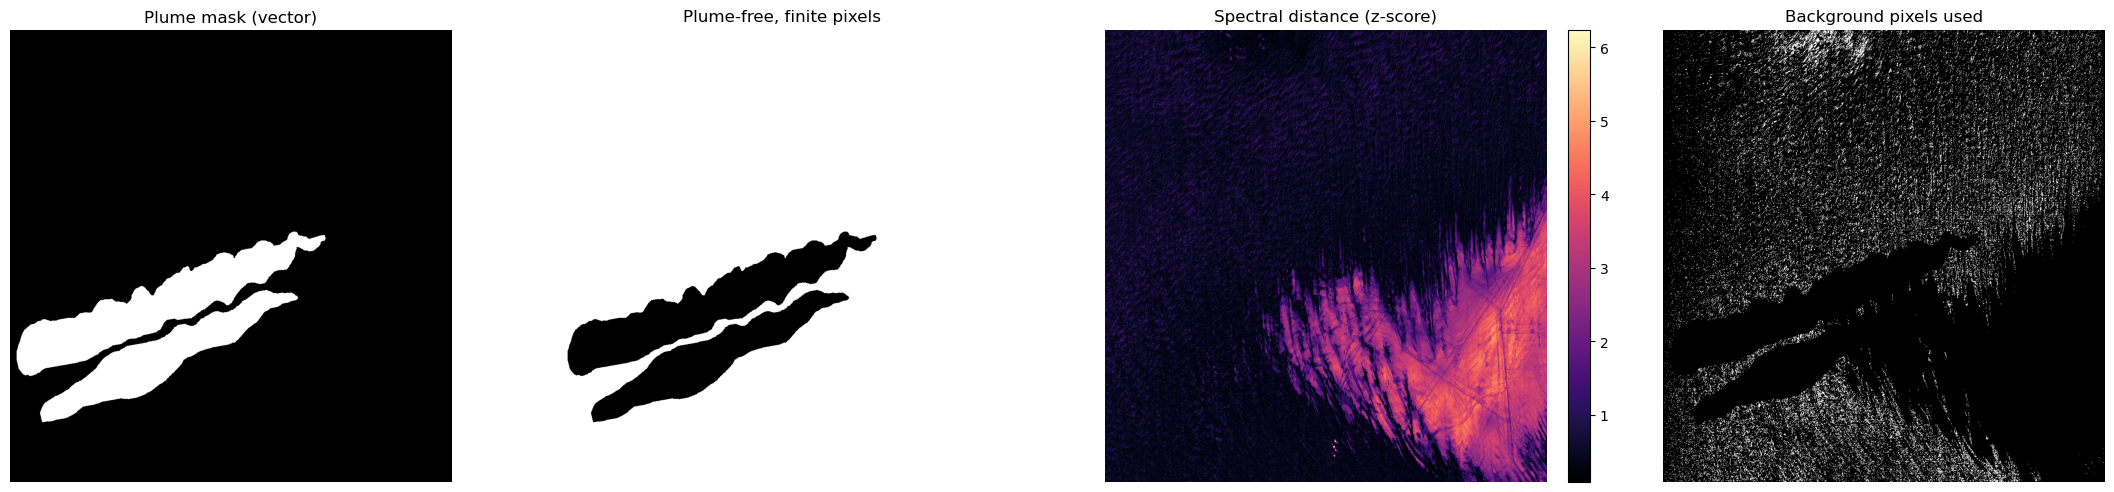

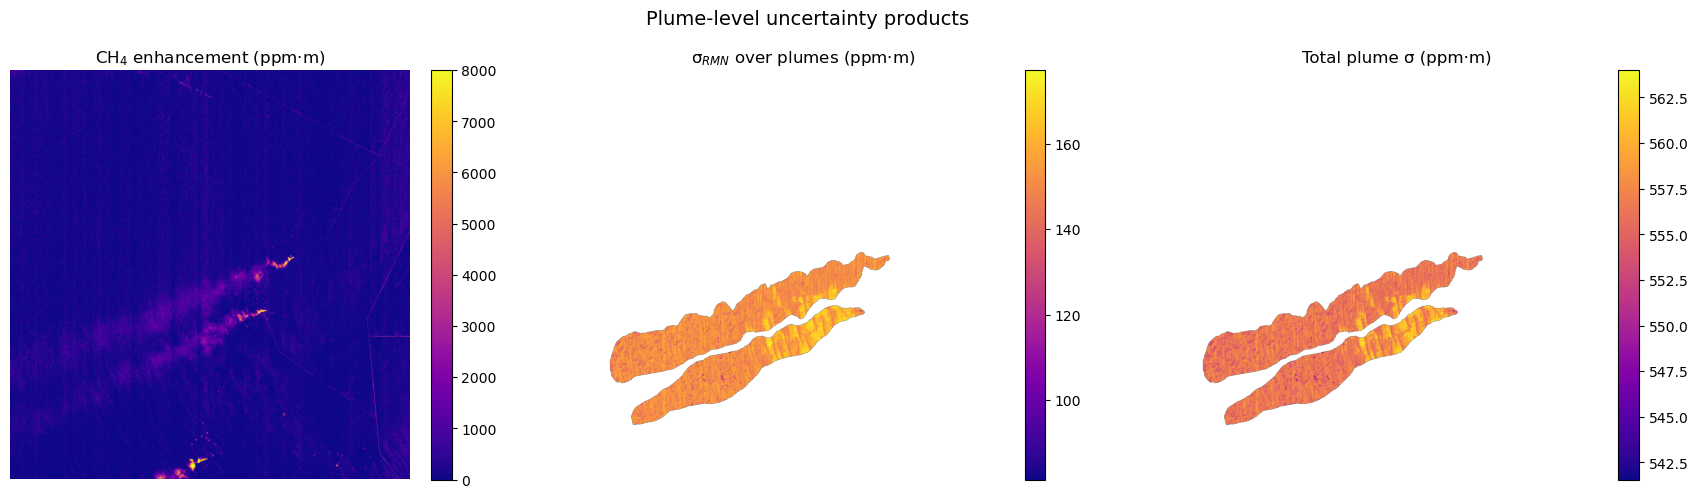

Scene noise metrics:
  scene: EnMAP Demo Scene (Turkmenistan plume)
  concentration_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/turkmenistan_plume/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif
  uncertainty_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/turkmenistan_plume/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif
  plume_mask_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/turkmenistan_plume/turkmenistan_plume_2022102T074833.shp
  plume_mask_source: vector
  auto_plume_threshold: None
  valid_pixels: 916429
  background_pixels: 91643
  background_strategy: spectrally_matched
  spectral_percentile: 10
  spectral_distance_threshold: 0.26652324199676514
  spectral_reference_pix

In [3]:

def _read_raster(path: str):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    ds = None
    return arr, geo, proj


def _rasterize_vector(vector_path: str, rows: int, cols: int, geo_transform: tuple, projection: str) -> np.ndarray:
    vector_ds = ogr.Open(vector_path)
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    vector_layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], vector_layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    vector_layer = None
    vector_ds = None
    return mask_array


def _slugify(value: str) -> str:
    return ''.join(ch.lower() if ch.isalnum() else '_' for ch in value).strip('_')


def _mask_array(data: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = np.full(data.shape, np.nan, dtype=float)
    masked[mask] = data[mask]
    return masked


def _auto_plume_mask(
    concentration: np.ndarray,
    finite_mask: np.ndarray,
    percentiles: tuple[float, ...],
    min_pixels: int,
):
    if not np.any(finite_mask):
        return None, {}
    values = concentration[finite_mask]
    if values.size == 0:
        return None, {}
    for perc in percentiles:
        threshold = float(np.nanpercentile(values, perc))
        candidate = (concentration >= threshold) & finite_mask
        if candidate.sum() >= min_pixels:
            return candidate, {'source': f'auto_percentile_{perc}', 'threshold': threshold}
    return None, {}


def _load_spectral_cube(assets: dict[str, Path | str]):
    required = ('vnir', 'swir', 'metadata')
    missing = [key for key in required if key not in assets]
    if missing:
        raise ValueError(f'Missing spectral asset keys: {", ".join(missing)}')
    cube, wavelengths, _, _, _, _ = enmap_utils.enmap_read(
        str(assets['vnir']),
        str(assets['swir']),
        str(assets['metadata']),
    )
    return cube.astype(np.float32), wavelengths.astype(np.float32)


# Ignore methane windows (plus a guard) so we only compare continuum-driven background structure
def _band_mask(wavelengths: np.ndarray, windows: list[tuple[float, float]], guard_nm: float) -> np.ndarray:
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        lower = lo - guard_nm
        upper = hi + guard_nm
        mask &= ~((wav >= lower) & (wav <= upper))
    return mask


# Mahalanobis-style distance on methane-free bands quantifies how plume-like each candidate pixel is
def _spectral_distance(cube: np.ndarray, ref_mean: np.ndarray, ref_std: np.ndarray) -> np.ndarray:
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized**2, axis=2))


def _select_background(
    distance_map: np.ndarray,
    candidate_mask: np.ndarray,
    percentiles: tuple[float, ...],
    min_fraction: float,
    min_pixels: int,
    fallback_percentile: float = 70.0,
):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile


def _derive_matched_background(scene_config: dict, plume_mask: np.ndarray | None, base_mask: np.ndarray):
    assets = scene_config.get('spectral_assets')
    if not assets:
        return base_mask, {'strategy': 'plume_free', 'reason': 'missing_assets', 'distance_map': None}
    if plume_mask is None or not np.any(plume_mask):
        return base_mask, {'strategy': 'plume_free', 'reason': 'missing_plume_mask', 'distance_map': None}
    cube, wavelengths = _load_spectral_cube(assets)
    windows = scene_config.get('methane_windows_nm', METHANE_WINDOWS_NM)
    guard = scene_config.get('methane_guard_nm', METHANE_GUARD_NM)
    usable_bands = _band_mask(wavelengths, windows, guard)
    if not np.any(usable_bands):
        return base_mask, {'strategy': 'plume_free', 'reason': 'no_usable_bands', 'distance_map': None}
    cube = cube[:, :, usable_bands]
    finite_cube = np.all(np.isfinite(cube), axis=2)
    plume_reference = cube[plume_mask & finite_cube]
    if plume_reference.size == 0:
        return base_mask, {'strategy': 'plume_free', 'reason': 'no_reference_pixels', 'distance_map': None}
    ref_mean = np.nanmedian(plume_reference, axis=0)
    ref_std = np.nanstd(plume_reference, axis=0, ddof=1)
    ref_std = np.where(ref_std > 0, ref_std, 1.0)
    distance_map = _spectral_distance(cube, ref_mean, ref_std)
    candidate_mask = base_mask & np.isfinite(distance_map)
    matched_mask, threshold, percentile = _select_background(
        distance_map,
        candidate_mask,
        scene_config.get('spectral_match_percentiles', SPECTRAL_MATCH_PERCENTILES),
        scene_config.get('min_background_fraction', MIN_BACKGROUND_FRACTION),
        scene_config.get('min_background_pixels', MIN_BACKGROUND_PIXELS),
    )
    if matched_mask.sum() == 0:
        return base_mask, {'strategy': 'plume_free', 'reason': 'selection_empty', 'distance_map': distance_map}
    return matched_mask, {
        'strategy': 'spectrally_matched',
        'percentile': percentile,
        'threshold': threshold,
        'reference_pixels': int(plume_reference.shape[0]),
        'usable_bands': int(cube.shape[2]),
        'distance_map': distance_map,
    }


concentration, geo_transform, projection = _read_raster(str(SCENE_CONFIG['concentration']))
uncertainty, _, _ = _read_raster(str(SCENE_CONFIG['uncertainty']))

if concentration.shape != uncertainty.shape:
    raise ValueError('Concentration and uncertainty rasters must share the same shape.')

plume_mask = None
plume_mask_source = 'none'
plume_mask_meta: dict[str, float] = {}
if SCENE_CONFIG.get('plume_mask') and SCENE_CONFIG['plume_mask'].exists():
    print(f"Using plume mask: {SCENE_CONFIG['plume_mask']}")
    plume_mask = _rasterize_vector(
        str(SCENE_CONFIG['plume_mask']),
        concentration.shape[0],
        concentration.shape[1],
        geo_transform,
        projection,
    )
    plume_mask_source = 'vector'
else:
    print('No plume shapefile found; attempting automatic plume mask from concentration percentiles.')

finite_only = np.isfinite(concentration) & np.isfinite(uncertainty)
if plume_mask is None:
    auto_mask, meta = _auto_plume_mask(
        concentration,
        finite_only,
        percentiles=AUTO_PLUME_PERCENTILES,
        min_pixels=AUTO_PLUME_MIN_PIXELS,
    )
    if auto_mask is not None:
        plume_mask = auto_mask
        plume_mask_source = meta.get('source', 'auto_percentile')
        plume_mask_meta = meta
        thresh = meta.get('threshold')
        if thresh is not None:
            print(f"Auto-derived plume mask ({plume_mask_source}) with threshold {thresh:.2f} ppm·m.")
        else:
            print(f'Auto-derived plume mask using {plume_mask_source} percentiles.')
    else:
        print('Automatic plume mask derivation failed; treating entire scene as plume-free background.')

if plume_mask is not None:
    plume_free_mask = ~plume_mask
else:
    plume_free_mask = np.ones_like(concentration, dtype=bool)

plume_free_finite_mask = plume_free_mask & finite_only
if not np.any(plume_free_finite_mask):
    raise ValueError('No valid plume-free pixels available for statistics.')

background_mask, background_info = _derive_matched_background(
    SCENE_CONFIG,
    plume_mask,
    plume_free_finite_mask,
)
if background_mask is None or not np.any(background_mask):
    background_mask = plume_free_finite_mask
    if background_info is None:
        background_info = {}
    background_info.setdefault('strategy', 'plume_free_fallback')

strategy = background_info.get('strategy', 'plume_free')
print(f'Background selection strategy: {strategy}')
if strategy == 'spectrally_matched':
    threshold = background_info.get('threshold')
    percentile = background_info.get('percentile')
    description = f"percentile={percentile}"
    if threshold is not None:
        description += f", threshold={threshold:.3f}"
    print(f"Matched {int(background_mask.sum())} pixels ({description}).")
else:
    print('Falling back to plume-free finite pixels for clutter estimation.')

distance_map = background_info.get('distance_map')
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
axes[0].imshow(plume_mask if plume_mask is not None else np.zeros_like(concentration, dtype=bool), cmap='gray')
axes[0].set_title(f'Plume mask ({plume_mask_source})')
axes[1].imshow(plume_free_finite_mask, cmap='gray')
axes[1].set_title('Plume-free, finite pixels')
if distance_map is not None:
    im = axes[2].imshow(np.ma.masked_invalid(distance_map), cmap='magma')
    axes[2].set_title('Spectral distance (z-score)')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
else:
    axes[2].imshow(np.zeros_like(concentration, dtype=float), cmap='gray')
    axes[2].set_title('Spectral distance unavailable')
axes[3].imshow(background_mask, cmap='gray')
axes[3].set_title('Background pixels used')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

delta_x = concentration[background_mask]
sigma_tot = float(np.nanstd(delta_x, ddof=1))

sigma_rmn_vals = uncertainty[background_mask]
agg = SIGMA_RMN_AGGREGATION.lower().strip()
if agg == 'median':
    sigma_rmn_stat = float(np.nanmedian(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmedian(sigma_rmn_vals ** 2))
else:
    sigma_rmn_stat = float(np.nanmean(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmean(sigma_rmn_vals ** 2))

# Remove the mean instrument variance from total plume-like variance to obtain the clutter term
sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))

if plume_mask is not None:
    plume_pixels_mask = plume_mask & finite_only
else:
    print('Plume mask missing: plume-level summaries will cover the whole scene.')
    plume_pixels_mask = finite_only

plume_pixel_count = int(plume_pixels_mask.sum())
if plume_pixel_count == 0:
    raise ValueError('No plume pixels available for plume-level uncertainty mapping.')

plume_concentration = _mask_array(concentration, plume_pixels_mask)
plume_sigma_rmn = _mask_array(uncertainty, plume_pixels_mask)
plume_sigma_total = _mask_array(np.sqrt(np.maximum(0.0, uncertainty ** 2 + sigma_surf ** 2)), plume_pixels_mask)

plume_sigma_rmn_mean = float(np.nanmean(plume_sigma_rmn[plume_pixels_mask]))
plume_sigma_total_mean = float(np.nanmean(plume_sigma_total[plume_pixels_mask]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[0].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plume_sigma_rmn, cmap='plasma')
axes[1].set_title('σ$_{RMN}$ over plumes (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plume_sigma_total, cmap='plasma')
axes[2].set_title('Total plume σ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes:
    ax.axis('off')

plt.suptitle('Plume-level uncertainty products', fontsize=14)
plt.tight_layout()
plt.show()

metrics = {
    'scene': SCENE_NAME,
    'concentration_path': str(SCENE_CONFIG['concentration']),
    'uncertainty_path': str(SCENE_CONFIG['uncertainty']),
    'plume_mask_path': str(SCENE_CONFIG['plume_mask']) if SCENE_CONFIG.get('plume_mask') else None,
    'plume_mask_source': plume_mask_source,
    'auto_plume_threshold': plume_mask_meta.get('threshold'),
    'valid_pixels': int(plume_free_finite_mask.sum()),
    'background_pixels': int(background_mask.sum()),
    'background_strategy': background_info.get('strategy'),
    'spectral_percentile': background_info.get('percentile'),
    'spectral_distance_threshold': background_info.get('threshold'),
    'spectral_reference_pixels': background_info.get('reference_pixels'),
    'spectral_usable_bands': background_info.get('usable_bands'),
    'methane_windows_nm': METHANE_WINDOWS_NM,
    'methane_guard_nm': METHANE_GUARD_NM,
    'plume_pixels': plume_pixel_count,
    'sigma_tot': sigma_tot,
    'sigma_rmn_sq': sigma_rmn_sq,
    'sigma_rmn_value': sigma_rmn_stat,
    'sigma_surf': sigma_surf,
    'sigma_rmn_aggregation': agg,
    'mean_plume_sigma_rmn': plume_sigma_rmn_mean,
    'mean_plume_sigma_total': plume_sigma_total_mean,
}

metrics_path = SUMMARY_DIR / f"{_slugify(SCENE_NAME)}_noise_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Scene noise metrics:')
for key, value in metrics.items():
    print(f'  {key}: {value}')
print(f'Saved metrics to {metrics_path}')





## Result interpretation
The JSON metrics now report whether the clutter term was derived from spectrally matched pixels (using methane-insensitive bands) or from the fallback plume-free mask. Inspecting the spectral-distance panel helps ensure the matched pixels truly track the plume's background before trusting $\sigma_{Surf}$ and the plume-level uncertainty mosaics.
